# 01 PyTorch Workflow Fundamentals
Link to lesson - https://www.learnpytorch.io/01_pytorch_workflow/

In [1]:
%load_ext autoreload
%autoreload 2

In [6]:
import torch
torch.__version__

'1.13.1'

In [3]:
import os
from torch import nn
import matplotlib.pyplot as plt

## Important Learnings
1. Learn to visualize the data whenever you can  
2. Any model can be built as Python classes that subclass pytorch's nn.Module  
    - Implementing the forward function inside your model class is necessary if it subclasses nn.Module  
    - nn.Module provides functionality to track bunch of very important stuff that you define in your model  
3. Usual training cycle is to forward pass, compute loss, clear optimizer gradients accumulated over previous steps, propagate loss backwards (which auto computes gradients wrt each trainable parameter), adjust weights using optimizer step, and repeat over epochs  
    - More details on how backprop happens in pt and computation of gradients in a separate section below  
    - This also sheds light on how to set and unset gradient calculation in pt models - which is helpful to get a deep understanding of how to setup model for training, inference, evaluation etc.  
4. PyTorch recommends loading and saving models via state_dict rather than the entire model [https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-entire-model]  
    - Saving the entire model (i.e. class) is not recommended as pickling will instead of saving the class as it is, save the path to the script that defines the class, creating a strong dependency on having the exact same directory structure (or path) to where the script defining the class is when later loading.  
    - The state_dict can on the other hand be saved as it is and loaded into a reconstructed model safely again  
5. The state_dict returned by __model.state\_dict( )__ is only a reference to the state_dict object. Meaning if I wish to store the state_dict of my best model, I will have to either pickle state_dict at every epoch or make a deepcopy of the one returned by model.state_dict(), else it'll get updated over future iterations and I'll lose it even if I only called this for the best model [https://pytorch.org/tutorials/beginner/saving_loading_models.html#save-load-state-dict-recommended]  
6. Difference between __torch.randn__ and __torch.rand__ to create a random number filled tensor of given shape is _randn()_ samples random numbers from a normal distribution with mean=0, std=1; while _rand()_ samples random numbers from a uniform distribution in the range \[0,1)

## AutoGrad & BackPropagation
AutoGrad is pytorch's automatic differentiation system to propagate loss backwards through every parameter of your model. It works by creating a DAG where the leaves are input tensors and the roots are outputs. Gradient is computed by consuming loss at the roots and driving back on the graph from roots to leaves, accumulating gradients at every node. [https://pytorch.org/docs/stable/notes/autograd.html#locally-disable-grad-doc]  
Important glances in this process -   
1. PT computes a autograd graph every time a forward pass is run. That means in every forward pass, a new graph is computed - giving us the flexibility to have custom forward pass in every iteration (potentially)  
    - all gradients are stored in the tensor's parameter _.grad_   
2. The gradient is defined by the __grad\_fn( )__ associated with any tensor that has _requires\_grad=True_ set  
    - PT has defined gradients of common functions  
    - PT also saves the input tensors for those _grad_fn( )_ for which it has internal support  
3. AutoGrad can only be run on elementary functions or composite functions whose elementary function elements have an internal support in PT. Support is defined not just as having a differentiation formula - it's a much more complex series of steps that PT checks and is able to use non-differentiable functions like relu with AutoGrad. Check steps here [https://pytorch.org/docs/stable/notes/autograd.html#gradients-for-non-differentiable-functions]  
  
  
It is often important to disable AutoGrad for models or specific parts of a model - like during testing, evaluation and inference. PT can do this in various different ways given below -  
1. Setting __requires\_grad=False__   
    - a graph node is recorded for AutoGrad only if at least one of the input tensors has _requires\_grad=True_  
    - this implies that only the input tensors really need requires_grad to be set, every following computation deriving from these input tensors will automatically be gradient enabled   
    - using this any parts of the model can be frozen  
    - remember settig any tensor (parameter) to requires_grad=False will freeze any following parameters that use only this as input - entire parts of models can be frozen this way  
    - all the parameters of a model can also be frozen by using _requires\_grad\_()_ on the model  
    - use __.requires\_grad\_( bool )__ to set a tensor's param at any time during computation  
2. Using context managers  
    - __torch.no\_grad( )__ this acts as if all input tensors to model are set to requires_grad == False  
        - Note it doesn't actually set these tensors to require_grad==False, just acts as if that was done  
        - Tensors created in this mode can be used beyond the context manager to be recorded in AutoGrad's graph if needed  
    - __torch.inference\_mode( )__ this is an extreme version of above with better speedup in computations  
        - Tensors created in this mode cannot be used beyond the context manager to be recorded in AutoGrad's graph  
    - __model.eval( )/model.train(False)__ this is completely different from both above  
        - This should be used to set parts of your network that should behave differently if they're being used for evaluation only like BatchNorm and DropOut  
        - One should always set model to eval when evaluation or inference agnostic of requires grad  

## Deeper dive into torch.nn

### Creating Dummy Data

In [7]:
weight, bias = 0.7, 0.3
start, end, step = 0, 1, 0.02
X = torch.arange(start, end, step)
y = weight*X + bias

In [8]:
X[:10], y[:10]

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]))

### Preparing Data
1. Splitting into train, test  
2. Visualizing data

In [9]:
train_frac = int(0.8*len(X))
X_train, X_test = X[:train_frac], X[train_frac:]
y_train, y_test = y[:train_frac], y[train_frac:]
len(X_train), len(X_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [10]:
def plot_predictions(train_data=X_train, train_labels=y_train, test_data=X_test, test_labels=y_test, predictions=None):
    
    plt.figure(figsize=(8,5))
    plt.scatter(train_data, train_labels, s=4, label="Train")
    plt.scatter(test_data, test_labels, s=4, label="Test")
    if not predictions is None:
        plt.scatter(test_data, predictions, s=4, label="Pred")
        
    plt.legend()
    plt.show()

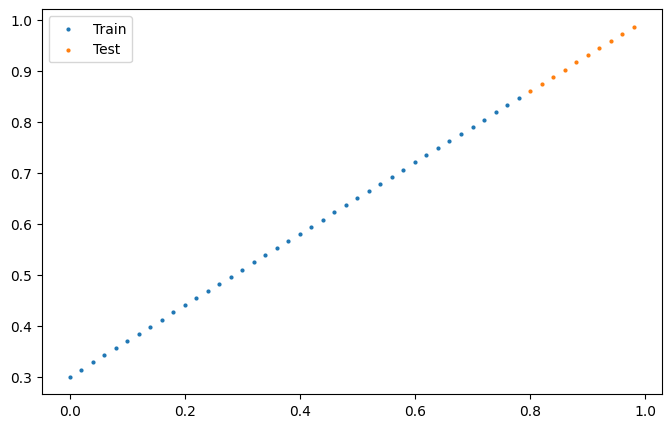

In [11]:
plot_predictions(X_train, y_train, X_test, y_test)

### Building the model
1. Any pytorch model can be built as a class that subclasses nn.Module  
2. nn.Module is a base class for any neural network in PyTorch (what exactly does this class code for?)  
3. When subclassing on nn.Module, a forward function should necessarily be define (my guess is this overloads the forward in nn.Module)  
4. __.parameters( )__ _(function)_ that returns an interator over all parameters defined in your model  
5. __.state_dict( )__ _(function)_ that returns a reference to all the parameters in your model as a python ordered dict  
6. __torch.inference_mode( )__ _(function)_ is a context manager that turns off many overhead computations of pytorch like gradient computing and graph creation etc. This is similar to torch.no_grad( ) but faster than it as it let's go of more overhead than the latter  


In [9]:
class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(1, requires_grad=True))
        self.bias = nn.Parameter(torch.randn(1, requires_grad=True))
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weight*x + self.bias

In [10]:
seed = 42
torch.manual_seed(seed)

In [11]:
model0 = LinearRegressionModel()

In [12]:
list(model0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [13]:
model0.state_dict()

OrderedDict([('weight', tensor([0.3367])), ('bias', tensor([0.1288]))])

In [14]:
with torch.inference_mode():
    y_pred = model0(X_test)

In [15]:
y_pred

tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])

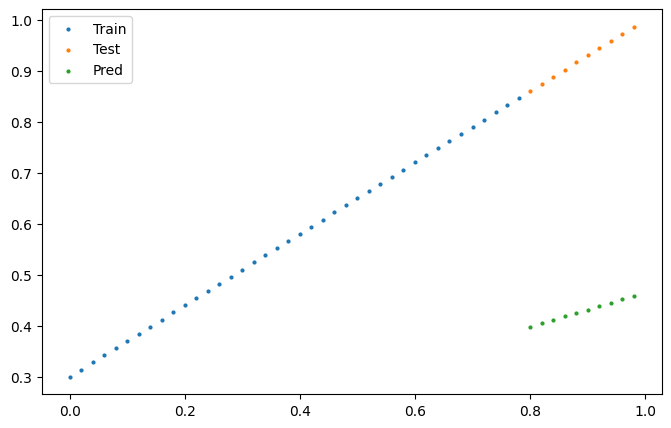

In [16]:
plot_predictions(X_train, y_train, X_test, y_test, y_pred)

In [17]:
errors = y_test - y_pred
errors

tensor([0.4618, 0.4691, 0.4764, 0.4836, 0.4909, 0.4982, 0.5054, 0.5127, 0.5200,
        0.5272])

### Training the model
1. Choosing an optimization method decides what formulae will be used to fit the model - Stochastic Gradient Descent is one of them, antother popular is Adam. __torch.optim.SGD( )/torch.optim.Adam( )__  
2. The optimization method will minimize/maximize a certain loss/probability  
    - Usually the Mean Absolute Error (MAE) __torch.nn.L1Loss( )__ is considered great for regression problem  
    - and the Binary Cross Entropy loss __torch.nn.BCE( )__ is considered awesome for binary classification problems   
3. The train loop in pt  
    - put the model in train mode (two modes = train, eval), by default the model is in train mode  
    - forward pass on train data  
    - compute loss from this pass with the chosen loss function  
    - clear optimizer gradients - it will accumulate over every pass  
    - backprop ie. compute gradient wrt every gradient=True parameter in your model  
    - have the optimizer update the parameters given the loss   
4. For every n epochs we save the epoch number and the train and test loss, this helps us visualize if the loss is going down with more training or not  

In [18]:
loss_function = nn.L1Loss()

In [19]:
optimizer = torch.optim.SGD(params = model0.parameters(), lr = 0.01)

In [1]:
torch.manual_seed(42)

epochs = 100
train_loss, test_loss, epoch_count = [], [], []

for epoch in range(epochs):
    
    model0.train()
    y_pred = model0(X_train)
    loss = loss_function(y_pred, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model0.eval()
    with torch.inference_mode():
        test_pred = model0(X_test)
        eval_loss = loss_function(test_pred, y_test.type(torch.float))
        
        if epoch%10==0:
            epoch_count.append(epoch//10)
            train_loss.append(loss.detach().numpy())
            test_loss.append(eval_loss.detach().numpy())
            print(f"Epoch : {epoch//10} | MAE train loss : {loss} | MAE test loss : {eval_loss}\n")

NameError: name 'torch' is not defined

[]

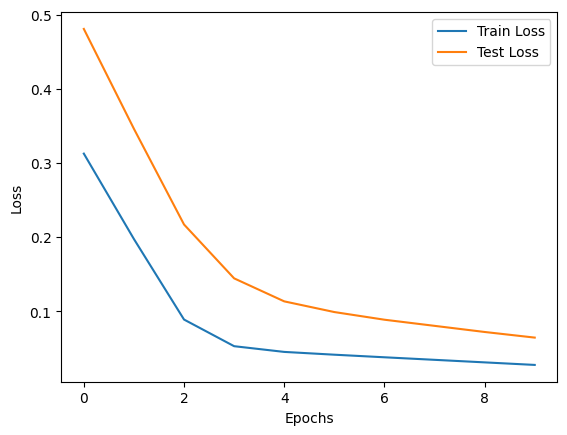

In [22]:
plt.plot(epoch_count, train_loss, label="Train Loss")
plt.plot(epoch_count, test_loss, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.plot()

In [23]:
model0.state_dict()

OrderedDict([('weight', tensor([0.5784])), ('bias', tensor([0.3513]))])

In [24]:
weight, bias

(0.7, 0.3)

### Inference using model
1. Set the model on eval mode and use with inference_mode context manager  
2. Make sure both data and model are on the same device, either cpu or gpu  

In [25]:
model0.eval()
with torch.inference_mode():
    y_pred = model0(X_test)
y_pred

tensor([0.8141, 0.8256, 0.8372, 0.8488, 0.8603, 0.8719, 0.8835, 0.8950, 0.9066,
        0.9182])

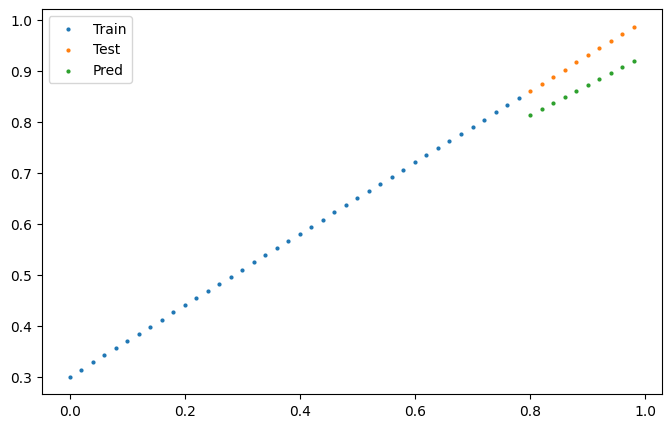

In [28]:
plot_predictions(predictions=y_pred)

### Loading and Saving PyTorch models
1. __torch.save( )__ pt's pickler that serialized models, tensors, state_dicts and other python objects as well and saved to disk, usually saved with a `.pt` or `.pth` extension    
2. __torch.load( )__ pt's unpickler to deseralize any object, can be loaded to a specific device as well  
3. __model.load\_state\_dict( torch.load( _path-to-saved-state-dict_ ) )__ to load a model's parameter state_dict from disk into another model - this is the recommended method to load models by pt docs   

In [31]:
#os.mkdir("models")

In [40]:
torch.save(model0.state_dict(), "models/linear_regressor_0.pt")

In [42]:
!ls models

linear_regressor_0.pt


In [43]:
loaded_state_dict = torch.load("models/linear_regressor_0.pt")

In [44]:
regressor0 = LinearRegressionModel()
regressor0.load_state_dict(loaded_state_dict)

<All keys matched successfully>

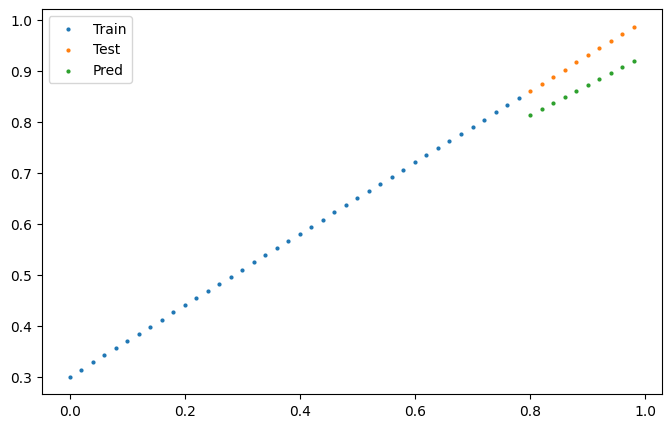

In [45]:
regressor0.eval()
with torch.inference_mode():
    y_pred = regressor0(X_test)
plot_predictions(predictions=y_pred)

### Revision of all steps above

In [12]:
import os

import torch
from torch import nn
import matplotlib.pyplot as plt

In [13]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
device

'mps'

In [14]:
class LinearRegressor(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(in_features=1, out_features=1)
        pass
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [15]:
torch.manual_seed(42)
model1 = LinearRegressor()

In [16]:
model1.state_dict()

OrderedDict([('linear.weight', tensor([[0.7645]])),
             ('linear.bias', tensor([0.8300]))])

In [17]:
lossfn = nn.L1Loss()
optSGD = torch.optim.SGD(model1.parameters(), lr=0.005)

In [18]:
model1.to(device)
X_train.to(device)
X_test.to(device)
y_train.to(device)
y_test.to(device)

/Users/vidhate/envs/ice2/lib/python3.10/site-packages/torch/_tensor_str.py:115: UserWarning: The operator 'aten::nonzero' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(


tensor([0.8600, 0.8740, 0.8880, 0.9020, 0.9160, 0.9300, 0.9440, 0.9580, 0.9720,
        0.9860], device='mps:0')

In [ ]:
epochs = 200
train_loss2, eval_loss2, epoch_count = [], [], []
batches = 

for epoch in range(epochs):
    model1.train()
    pred = model1(X_train)
    tloss = lossfn(pred, y_train)
    optSGD.zero_grad()
    tloss.backward()
    optSGD.step()
    
    if epoch%10 == 0:
        model1.eval()
        with torch.inference_mode():

            y_pred = model1(X_test)
            eloss = lossfn(y_pred, y_test.type(torch.float))
            epoch_count.append(epoch//10)
            train_loss2.append(tloss)
            eval_loss2.append(eloss)
            
            print(f"Epoch : {epoch} | MAE train : {tloss} | MAE eval : {eloss}\n")

In [74]:
model1.eval()
with torch.inference_mode():
    y_pred = model1(X_test)
y_pred

tensor([0.8139, 0.8255, 0.8370, 0.8486, 0.8602, 0.8718, 0.8833, 0.8949, 0.9065,
        0.9180])

In [76]:
torch.save(model1.state_dict(), "models/linear_regressor_1.pth")

In [81]:
loaded_state_dict1 = torch.load("models/linear_regressor_1.pth")
model1_copy = LinearRegressor()
model1_copy.load_state_dict(loaded_state_dict1)

<All keys matched successfully>

In [82]:
model1_copy.eval()
with torch.inference_mode():
    y_pred2 = model1_copy(X_test)
y_pred2==y_pred

tensor([True, True, True, True, True, True, True, True, True, True])